In [123]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime
import warnings

import talib
from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [180]:
class MarketRegimes():
    """
    A Class used to represent an trend and volatility regime of data series
    """
    # Trend level
    StrongBull = 2
    Bull = 1
    Neutral = 0
    Bear = -1
    StrongBear = -2
    
    # Volatility level
    VeryVolatily = 3
    Volatility = 2
    Normal = 1
    Quiet = 0
    
    hmm_model = None
    data : pd.DataFrame = None
    
    def __init__(self, dataFrame):
        self.data = dataFrame.copy()
    
    def market_trend_regimes_bb(self, LongPeriod1=200, LongPeriod2=50):    
        self.data['UpperBBLong1'] = self.data['Close'].rolling(LongPeriod1).mean() + \
                            0.5 * self.data['Close'].rolling(LongPeriod1).std()        
        self.data['UpperBBLong2'] = self.data['Close'].rolling(LongPeriod2).mean() + \
                            0.5 * self.data['Close'].rolling(LongPeriod2).std()
        self.data['LowerBBLong1'] = self.data['Close'].rolling(LongPeriod1).mean() - \
                            0.5 * self.data['Close'].rolling(LongPeriod1).std()        
        self.data['LowerBBLong2'] = self.data['Close'].rolling(LongPeriod2).mean() - \
                            0.5 * self.data['Close'].rolling(LongPeriod2).std()
        
        self.data['LongTrend'] = np.nan
        
        # Long Term Trend
        self.data['LongTrend'] = np.where(
                (self.data.Close > self.data.UpperBBLong1),
                self.Bull,
                self.data.LongTrend
            )
        
        self.data['LongTrend'] = np.where(
                (self.data.Close > self.data.UpperBBLong1) & (self.data.Close > self.data.UpperBBLong2),
                self.StrongBull,
                self.data.LongTrend
            )
        
        self.data['LongTrend'] = np.where(
                (self.data.Close < self.data.UpperBBLong1) & (self.data.Close > self.data.LowerBBLong1),
                self.Neutral,
                self.data.LongTrend
            )
        
        self.data['LongTrend'] = np.where(
                (self.data.Close < self.data.LowerBBLong1),
                self.Bear,
                self.data.LongTrend
            )
        
        self.data['LongTrend'] = np.where(
                (self.data.Close < self.data.LowerBBLong1) & (self.data.Close < self.data.LowerBBLong2),
                self.StrongBear,
                self.data.LongTrend
            )
        
        bb = ['UpperBBLong1', 'UpperBBLong2', 'LowerBBLong1', 'LowerBBLong2']
        self.data.drop(columns=bb, inplace=True)
        

    def market_trend_regimes_ROC(self, LongPeriod=63, threshold1=7, threshold2=4, threshold3=-2, threshold4=-5):     
        self.data['ROCLong'] = (self.data.Close / self.data.Close.shift(LongPeriod) - 1) * 100
        self.data['ROCLongTrend'] = np.nan
        self.data['ROCLongTrend'] = np.where(
                self.data.ROCLong > threshold1,
                self.StrongBull,
                self.data.ROCLongTrend
                )
        self.data['ROCLongTrend'] = np.where(
                (self.data.ROCLong <= threshold1) & (self.data.ROCLong > threshold2),
                self.Bull,
                self.data.ROCLongTrend
                )
        self.data['ROCLongTrend'] = np.where(
                (self.data.ROCLong <= threshold2) & (self.data.ROCLong > threshold3),
                self.Neutral,
                self.data.ROCLongTrend
                )
        self.data['ROCLongTrend'] = np.where(
                (self.data.ROCLong <= threshold3) & (self.data.ROCLong > threshold4),
                self.Bear,
                self.data.ROCLongTrend
                )
        self.data['ROCLongTrend'] = np.where(
                self.data.ROCLong <= threshold4,
                self.StrongBear,
                self.data.ROCLongTrend
                )
        self.data.drop(columns=['ROCLong'], inplace=True)
        
    def market_trend_regimes_hmm(self, nState):
        df = self.data.copy()
        df.dropna(inplace=True)
        
        # Train returns
        X = np.column_stack([df['Returns']])

        # Create the Gaussian Hidden markov Model and fit
        self.hmm_model = GaussianHMM(
            n_components=nState, covariance_type="full", random_state=1, n_iter=1000
        ).fit(X)
        print(f'Converged: {self.hmm_model.monitor_.converged}\t\t Model Score: {self.hmm_model.score(X)}')
        
        hidden_states = self.hmm_model.predict(X)
        
        offset = len(self.data) - len(df)
        hidden_states = np.append(hidden_states, offset*[100]) # Add 100 to make array length same data length
        
        self.data['HMM Trend'] = hidden_states
        self.data['HMM Trend'] = self.data['HMM Trend'].shift(offset)
        
    def market_volatility_regimes_atrp(self, PERIOD=21, Mean=504, Std=1):
        self.data['ATRP'] = talib.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=PERIOD) / self.data['Close'] * 100
        self.data['ATRPThreshold1'] = self.data.ATRP.rolling(Mean).mean() + 3*self.data.ATRP.rolling(Mean).std()
        self.data['ATRPThreshold2'] = self.data.ATRP.rolling(Mean).mean() + self.data.ATRP.rolling(Mean).std()
        self.data['ATRPThreshold3'] = self.data.ATRP.rolling(Mean).mean() - self.data.ATRP.rolling(Mean).std()
        self.data['Volatility'] = np.nan
        self.data['Volatility'] = np.where(
                self.data.ATRP >= self.data.ATRPThreshold1,
                self.VeryVolatily,
                self.data.Volatility
                )
        self.data['Volatility'] = np.where(
                (self.data.ATRP >= self.data.ATRPThreshold2) & (self.data.ATRP < self.data.ATRPThreshold1),
                self.Volatility,
                self.data.Volatility
                )
        self.data['Volatility'] = np.where(
                (self.data.ATRP > self.data.ATRPThreshold3) & (self.data.ATRP < self.data.ATRPThreshold2),
                self.Normal,
                self.data.Volatility
                )
        self.data['Volatility'] = np.where(
                self.data.ATRP <= self.data.ATRPThreshold3,
                self.Quiet,
                self.data.Volatility
                )
        self.data.drop(columns=['ATRP', 'ATRPThreshold1', 'ATRPThreshold2', 'ATRPThreshold3'], inplace=True)
    
    def market_volatility_regimes_hmm(self, nState, atr_period):
        df = self.data.copy()
        df.dropna(inplace=True)
        
        df['ATRP'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_period) / df['Close'] * 100      
        df.dropna(inplace=True)
        
        X = np.column_stack([df['ATRP']])
        
        # Create the Gaussian Hidden markov Model and fit
        self.hmm_model = GaussianHMM(
            n_components=nState, covariance_type="full", random_state=1, n_iter=1000
        ).fit(X)
        print(f'Converged: {self.hmm_model.monitor_.converged}\t\t Model Score: {self.hmm_model.score(X)}')
        
        hidden_states = self.hmm_model.predict(X)
        
        offset = len(self.data) - len(df)
        hidden_states = np.append(hidden_states, offset*[100]) # Add 100 to make array length same data length
        self.data['HMM Volatility'] = hidden_states
        self.data['HMM Volatility'] = self.data['HMM Volatility'].shift(offset)
            
    
    def market_regimes_plot_color(self, dataname, trend, fromDate, toDate, kind='color'):
        """
        Refer: https://stackoverflow.com/questions/31590184/plot-multicolored-line-based-on-conditional-in-python
        """
        df = self.data.loc[fromDate:toDate,:].copy()
        df = df.dropna(axis=0, how='any')
        
        # Create plot
        fig, ax = plt.subplots(nrows=2, ncols=1)
        
        if kind == 'color':
            ## Convert Trend to colors
            if trend == 'HMM Volatility' or trend == 'Volatility':
                trend2color = {0:'green', 1:'red', 2:'y', 3:'cyan'}                
            else:
                trend2color = {-2: 'cyan', -1:'red', 0:'y', 1:'green', 2:'magenta'}
            df['color'] = df[trend].apply(lambda trend: trend2color[trend])
            
            def gen_repeating(s):
                """Generator: groups repeated elements in an iterable
                E.g.
                    'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
                """
                i = 0
                while i < len(s):
                    j = i
                    while j < len(s) and s[j] == s[i]:
                        j += 1
                    yield (s[i], i, j-1)
                    i = j
                    
            ## Add Close Price lines
            for color, start, end in gen_repeating(df['color']):
                if start > 0: # make sure lines connect
                    start -= 1
                idx = df.index[start:end+1]
                df.loc[idx, 'Close'].plot(ax=ax[0],figsize=(12,10), color=color, label='')
            
            ## Get artists and labels for legend and chose which ones to display
            handles, labels = ax[0].get_legend_handles_labels()
            
            ## Create custom artists
            c_line = plt.Line2D((0,1),(0,0), color='cyan')
            r_line = plt.Line2D((0,1),(0,0), color='red')
            y_line = plt.Line2D((0,1),(0,0), color='y')
            g_line = plt.Line2D((0,1),(0,0), color='green')        
            v_line = plt.Line2D((0,1),(0,0), color='magenta')
            
            ## Create legend from custom artist/label lists
            if trend == 'HMM Volatility':
                ax[0].legend(
                    handles + [g_line, r_line, y_line, c_line],
                    labels + [
                        'State 1',
                        'State 2',
                        'State 3',
                        'State 4'
                    ],
                    loc='best',
                )
            elif trend == 'Volatility':
                ax[0].legend(
                    handles + [g_line, r_line, y_line, c_line],
                    labels + [
                        'Quiet',
                        'Normal',
                        'Volatily',
                        'Very Volatily'
                    ],
                    loc='best',
                )
            elif trend == 'HMM Trend':
                ax[0].legend(
                    handles + [g_line, r_line, y_line, c_line, v_line],
                    labels + [
                        'State 1',
                        'State 2',
                        'State 3',
                        'State 4',
                        'State 5'
                    ],
                    loc='best',
                )
            else:
                ax[0].legend(
                    handles + [c_line, r_line, y_line, g_line, v_line],
                    labels + [
                        'Strong Bear',
                        'Bear',
                        'Neutral',
                        'Bull',
                        'Strong Bull'
                    ],
                    loc='best',
                )
        elif kind == 'line':
            df[['Close', trend]].plot(ax=ax[0], figsize=(12,10), secondary_y = trend)
        else:
            print(f'Doesnt support this kind: {kind} of plot')
        
        if trend == 'Volatility' or trend == 'HMM Volatility':
            df['Returns'].plot(ax=ax[1])
        else:
            fig.delaxes(ax[1])
            
        fromDate_str = df.index[0].strftime("%d/%m/%Y")
        toDate_str = df.index[-1].strftime("%d/%m/%Y")
        ax[0].set_title(dataname + ' ' + trend + ' ' + fromDate_str + ' ' + toDate_str)
        
        plt.show()

### Apply market regime on VNINDEX daily data

In [231]:
vnindex = pd.read_csv('VNINDEX.csv', index_col=0, parse_dates=True)
vnindex['Returns'] = vnindex['Close'].pct_change()
vni_regimes = MarketRegimes(vnindex)

In [125]:
# BB Trend
vni_regimes.market_trend_regimes_bb()

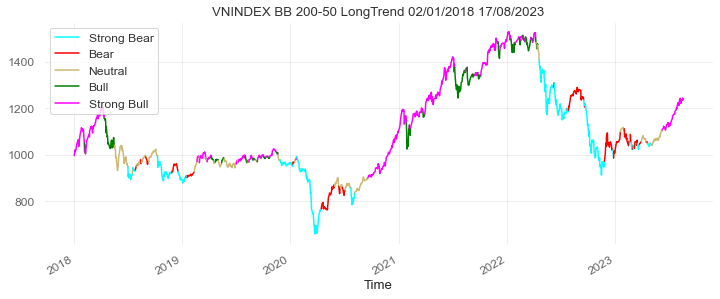

In [126]:
# Trend Regimes BB Plot
fromTime = datetime.datetime.strptime("01/01/2018", "%d/%m/%Y")
toTime = datetime.datetime.now()
vni_regimes.market_regimes_plot_color('VNINDEX BB 200-50', 'LongTrend', fromTime, toTime, kind='color')

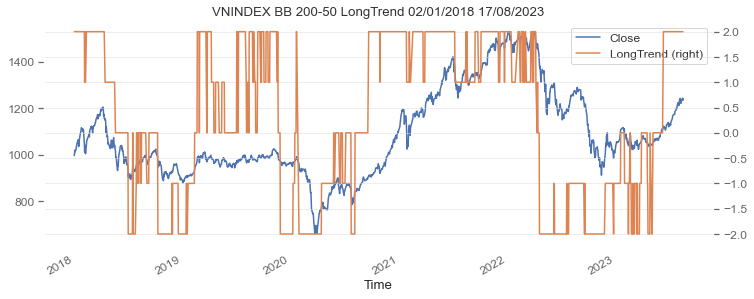

In [127]:
vni_regimes.market_regimes_plot_color('VNINDEX BB 200-50', 'LongTrend', fromTime, toTime, kind='line')

In [128]:
# ROC Trend
vni_regimes.market_trend_regimes_ROC()

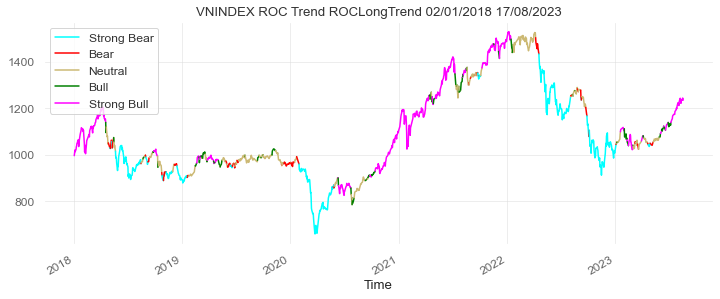

In [129]:
vni_regimes.market_regimes_plot_color('VNINDEX ROC Trend', 'ROCLongTrend', fromTime, toTime, kind='color')

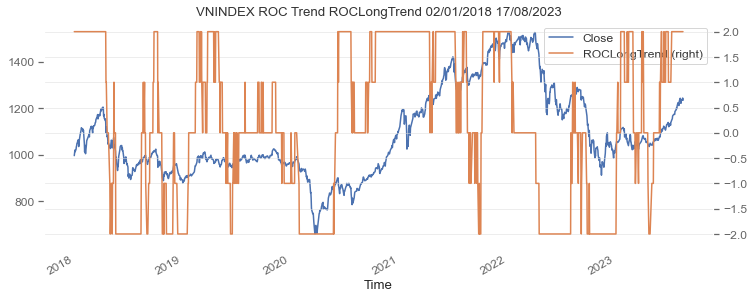

In [130]:
vni_regimes.market_regimes_plot_color('VNINDEX ROC Trend', 'ROCLongTrend', fromTime, toTime, kind='line')

In [233]:
# HMM Trend
vni_regimes.market_trend_regimes_hmm(nState=3)

Model is not converging.  Current: 6884.2536881459955 is not greater than 6884.311258596664. Delta is -0.05757045066820865


Converged: True		 Model Score: 6884.165299862176


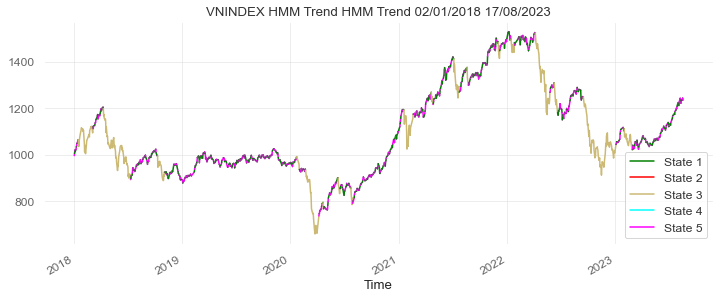

In [234]:
vni_regimes.market_regimes_plot_color('VNINDEX HMM Trend', 'HMM Trend', fromTime, toTime, kind='color')

In [133]:
# ATRP Volatility
vni_regimes.market_volatility_regimes_atrp(Mean=252)

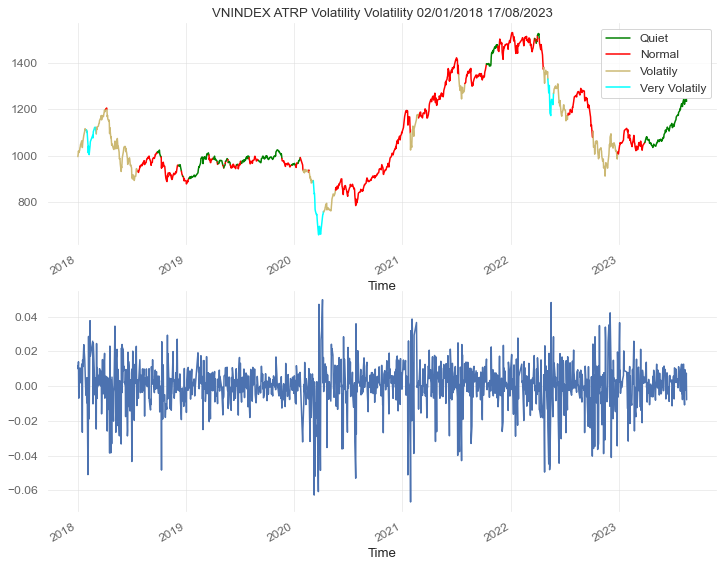

In [134]:
vni_regimes.market_regimes_plot_color('VNINDEX ATRP Volatility', 'Volatility', fromTime, toTime, kind='color')

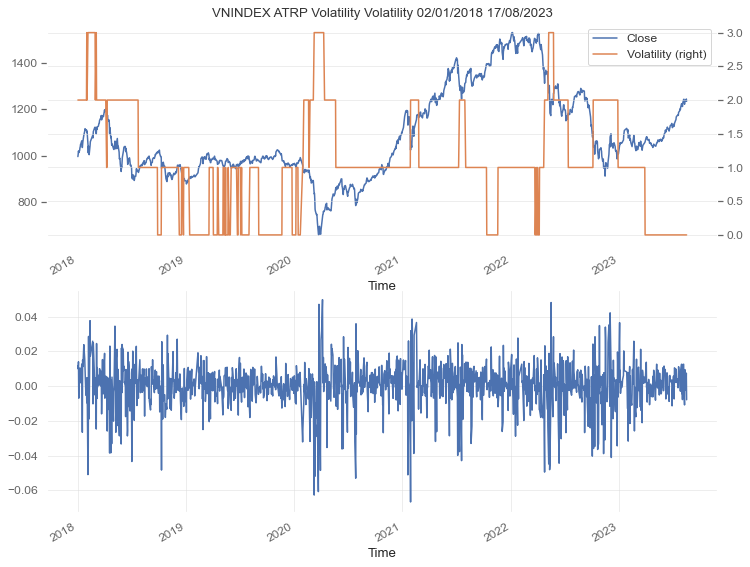

In [135]:
vni_regimes.market_regimes_plot_color('VNINDEX ATRP Volatility', 'Volatility', fromTime, toTime, kind='line')

In [136]:
# HMM Volatility
vni_regimes.market_volatility_regimes_hmm(nState=4, atr_period=21)

Converged: True		 Model Score: 312.94393694167405


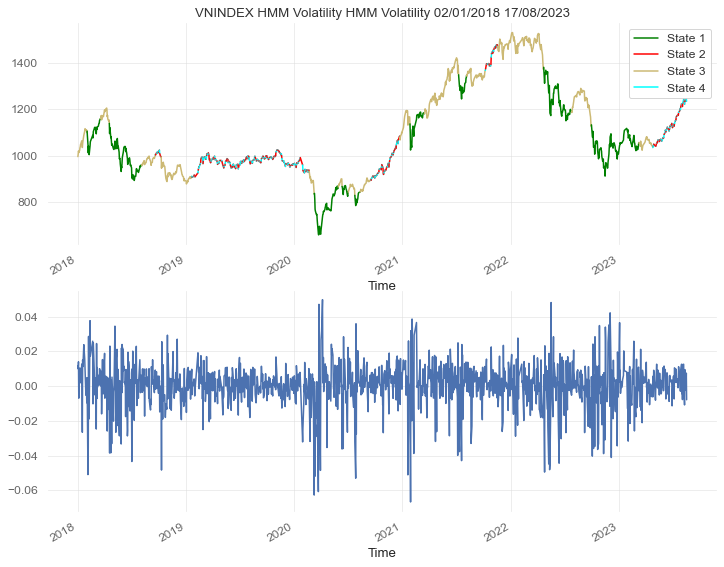

In [137]:
vni_regimes.market_regimes_plot_color('VNINDEX HMM Volatility', 'HMM Volatility', fromTime, toTime, kind='color')

## Create Trading strategy

In [109]:
import quantstats as qs

In [172]:
class StrategyPerformance():
    stg_df : pd.DataFrame = None
    position_tbl : pd.DataFrame = None
    
    stg_name : str = None
    stg_type : str = None
    stg_period : str = None
    numOfTrade : int = 0
    winTrade : int = 0
    loseTrade : int = 0
    winRate : float = 0
    avgPnL : float = 0
    profitFactor : float = 0
    avgBarsHeld : float = 0
    CAGR : float = 0
    vol : float = 0
    maxDD : float = 0
    sharpe : float = 0
    
    rf : float = None
    timeToYear = {'1m': 243*252, '5m': np.ceil(243*252/5), '15m': np.ceil(243*252/15),
                  '30m': np.ceil(243*252/30), '1H': 5*252, '1D':252, 'M':12, 'Q':4, 'Y':1}
    
    def __init__(self, dataFrame, name, stg_type, period = "1D", riskFree = 0, pnl_exist = False, pnl_col='PnL'):
        self.stg_df = dataFrame.copy()
        self.stg_period = period
        self.rf = riskFree
        self.stg_name = name
        self.stg_type = stg_type
        if pnl_exist == False:
            self.stg_df['PnL'] = self.stg_df['Position'] * self.stg_df['Returns']
        else:
            self.stg_df.rename(columns={pnl_col: 'PnL'}, inplace=True)
        
        self.position_summary()
        self.profit_factor()
        self.max_dd()
        self.volatility()
        self.CAGR()
        self.sharpe_ratio()
        
        
    def position_summary(self):
        data = self.stg_df.copy()
        data.fillna(0, inplace=True)
        
        cols = ['Open Date', 'Open Price', 'Close Date', 'Close Price', 'Type', 'Expired']
        self.position_tbl = pd.DataFrame(columns=cols)
        total_bar = 0
        
        if self.stg_type == 'Daily':
            tmp_df = data[data.Position != 0]

            self.position_tbl['Open Date'] = tmp_df.index.values
            self.position_tbl['Close Date'] = tmp_df.index.values
            self.position_tbl['Open Price'] = tmp_df['Open'].values
            self.position_tbl['Close Price'] = tmp_df['Close'].values
            self.position_tbl['Type'] = tmp_df['Position'].values
            self.position_tbl['Expired'] = False
            
            total_bar = len(self.position_tbl)
        else:
            pre_pos = 0
            cur_pos = 0
            num = 0
            open_bar = 0
            
            for bar in range(len(self.stg_df)):
                idx = data.index[bar]
                cur_date = idx.date()
                cur_date_str = cur_date.strftime("%d/%m/%Y")
                cur_time = idx.time()
                try:
                    pre_pos = data.iloc[bar-1]['Position']
                    cur_pos = data.iloc[bar]['Position']
                    if cur_pos == pre_pos:
                        continue
                    
                    # Open Position
                    if (cur_pos != 0) and (pre_pos != cur_pos):
                        open_date = idx
                        open_price = data.iloc[bar]['Open']

                        close_date = None
                        close_price = np.nan
                        expired = False
                        # Type 1 is long position, type -1 is short position
                        pos_type =  data.iloc[bar]['Position']
                        new_post = pd.DataFrame([[open_date, open_price, close_date, close_price, pos_type, expired]], index=[num], columns=cols)
                        self.position_tbl = pd.concat([self.position_tbl, new_post])
                        open_bar = bar
                    
                    # Close position
                    if (pre_pos != 0) and (cur_pos != pre_pos):
                        close_date = idx
                        close_price = data.loc[idx, 'Close']
                        self.position_tbl.loc[num, 'Close Date'] = close_date
                        self.position_tbl.loc[num, 'Close Price'] = close_price
                        """
                        eod_time = datetime.time(14, 45, 59)
                        if (cur_date_str in expire_date) and (cur_time == eod_time):
                            self.position_tbl.loc[num, 'Expired'] = True
                        """
                        num = num + 1
                        total_bar += bar - open_bar
                        open_bar = 0
                    
                except Exception as e:
                    print(e)
        
        try:
            self.position_tbl['Result'] = (self.position_tbl['Close Price'] - self.position_tbl['Open Price']) * self.position_tbl['Type']
            self.position_tbl['Returns'] = self.position_tbl['Result'] / self.position_tbl['Open Price']
            
            self.winTrade = self.position_tbl[self.position_tbl['Result'] > 0]['Open Date'].count()
            self.loseTrade = self.position_tbl[self.position_tbl['Result'] <= 0]['Open Date'].count()
            self.numOfTrade = len(self.position_tbl)
            self.winRate = self.winTrade / self.numOfTrade
            self.avgPnL = self.position_tbl['Returns'].sum() / self.numOfTrade
            self.avgBarsHeld = total_bar / self.numOfTrade
        except Exception as e:
            print(e)
        
    def profit_factor(self):
        df = self.position_tbl.copy()
        try:
            loseRate = self.loseTrade / self.numOfTrade
            avgWinReturns = df[df['Result'] > 0]['Returns'].sum() / self.winTrade
            avgLoseReturns = df[df['Result'] <= 0]['Returns'].sum() / self.loseTrade
            self.profitFactor = (avgWinReturns * self.winRate) / (abs(avgLoseReturns) * loseRate)
        except Exception as e:
            print(e)
    
    def max_dd(self):
        self.stg_df['Cum Returns'] = (1 + self.stg_df['PnL']).cumprod()
        self.stg_df['Cum Max'] = self.stg_df['Cum Returns'].cummax()
        self.stg_df['Drawdown'] = self.stg_df['Cum Max'] - self.stg_df['Cum Returns']
        self.stg_df['Drawdown Pct'] = self.stg_df['Drawdown'] / self.stg_df['Cum Max']
        self.maxDD = self.stg_df['Drawdown Pct'].max()
        
    def CAGR(self):
        self.stg_df['Cum Returns'] = (1 + self.stg_df['PnL']).cumprod()
        n = len(self.stg_df) / self.timeToYear[self.stg_period]
        self.CAGR = self.stg_df['Cum Returns'].tolist()[-1]**(1/n) - 1
    
    def volatility(self):
        self.vol = self.stg_df['PnL'].std() * np.sqrt(self.timeToYear[self.stg_period])
    
    def sharpe_ratio(self):
        self.sharpe = (self.CAGR - self.rf) / self.vol
        
    def strategy_performance(self):
        print(f'------------------------{self.stg_name} Performance--------------------')
        print(f'Number of Trades: {self.numOfTrade}')
        print(f'Win Trades: {self.winTrade}')
        print(f'Lose Trades: {self.loseTrade}')
        print(f'Win Rate: {self.winRate * 100} %')
        print(f'Average Bars Held: {self.avgBarsHeld}')
        print(f'Strategy Cumulative Annual Growth Rate: {self.CAGR * 100} %')
        print(f'Average Return Per trade: {self.avgPnL * 100} %')
        print(f'Profit Factor: {self.profitFactor}')
        print(f'Strategy Volatility: {self.vol}')
        print(f'Strategy Sharpe Ratio: {self.sharpe}')
        print(f'Stragegy Max Drawdown: {self.maxDD * 100} %')
        print('--------------------------------------------------------------')
    
    def stg_cum_returns_plot(self):
        fig, ax = plt.subplots()
        self.stg_df['Cum Returns'].plot(figsize=(12,8))
        plt.title(f'{self.stg_name} strategy Cummulative Returns')
        plt.ylabel('Cum Return')
        plt.xlabel('Date')
        fig.autofmt_xdate()
        ax.legend([self.stg_name])
        plt.show()        
    
    def stg_cum_returns_benchmark_plot(self):
        fig, ax = plt.subplots()
        plt.plot(self.stg_df['Cum Returns'])
        plt.plot((1 + self.stg_df['Returns']).cumprod())
        plt.plot((1 - self.stg_df['Returns']).cumprod())
        plt.title(f'{self.stg_name} strategy Cummulative Returns')
        plt.ylabel('Cum Return')
        plt.xlabel('Date')
        fig.autofmt_xdate()
        ax.legend([self.stg_name, 'VN30F1M Long Only', 'VN30F1M Short Only'])
        plt.show()
    
    def performance_report(self, benchmark=None, benchmark_col='Returns'):
        if benchmark == 'LO':
            benchmark_data = self.stg_df[benchmark_col]
        elif benchmark == 'SO':
            benchmark_data = -self.stg_df[benchmark_col]
            
        qs.reports.full(self.stg_df['PnL'], benchmark=benchmark_data)
    
    def performance_report_html(self, benchmark=None, benchmark_col='Returns'):
        benchmark_data = None
        folder = 'TestResult/'
        filename =  folder + self.stg_name.replace(' ', '') + benchmark + '_tearsheet.html'
        
        if benchmark == 'LO':
            benchmark_data = self.stg_df[benchmark_col]
        elif benchmark == 'SO':
            benchmark_data = -self.stg_df[benchmark_col]
            
        qs.reports.html(self.stg_df['PnL'], benchmark=benchmark_data , output=folder, download_filename=filename, title=self.stg_name)

#### Strategy base on BB trend

Open Long Position when market regime change from strong bear to higher state or bull to strong bull.
Close Position when market regime change from strong bull to lower state or bear to strong bear

In [218]:
vni_regimes = MarketRegimes(vnindex)
vni_regimes.market_trend_regimes_bb()

strategy_bb = vni_regimes.data.copy()
strategy_bb['Returns'] = np.log(strategy_bb.Close) - np.log(strategy_bb.Close.shift(1))
strategy_bb.dropna(inplace = True)
strategy_bb['Position'] = np.nan

In [220]:
for i in range(1, len(strategy_bb)):
    index = strategy_bb.index[i]

    prev_regime = strategy_bb.iloc[i-1]['LongTrend']
    cur_regime = strategy_bb.iloc[i]['LongTrend']
    if (cur_regime == vni_regimes.Bull and prev_regime == vni_regimes.StrongBull) or \
        (cur_regime == vni_regimes.StrongBear and prev_regime == vni_regimes.Bear):
        strategy_bb.loc[index, 'Position'] = 0

    if (cur_regime == vni_regimes.Bear and prev_regime == vni_regimes.StrongBear) or \
        (cur_regime == vni_regimes.StrongBull and prev_regime == vni_regimes.Bull):
        strategy_bb.loc[index, 'Position'] = 1
        
strategy_bb['Position'] = strategy_bb['Position'].fillna(method = 'ffill')
strategy_bb['Position'] = np.where(np.isnan(strategy_bb.Position), 0, strategy_bb.Position)
strategy_bb['Position'] = strategy_bb['Position'].shift(1)
strategy_bb.dropna(inplace = True)

In [221]:
performance = StrategyPerformance(strategy_bb, 'Long VNINDEX based on Long Trend BB 200-50', 'Swing')
performance.strategy_performance()

------------------------Long VNINDEX based on Long Trend BB 200-50 Performance--------------------
Number of Trades: 53
Win Trades: 23
Lose Trades: 30
Win Rate: 43.39622641509434 %
Average Bars Held: 23.0188679245283
Strategy Cumulative Annual Growth Rate: 8.484984855392664 %
Average Return Per trade: 1.1409864175219064 %
Profit Factor: 2.1164843261952866
Strategy Volatility: 0.13747650088809604
Strategy Sharpe Ratio: 0.6171952879641098
Stragegy Max Drawdown: 36.45965159365943 %
--------------------------------------------------------------


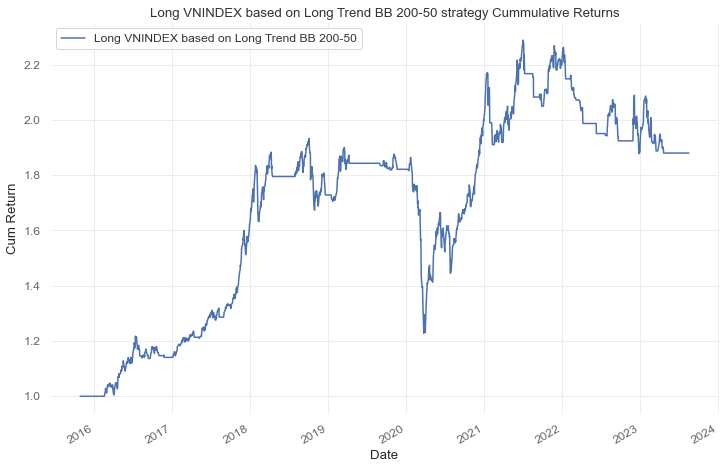

In [222]:
performance.stg_cum_returns_plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-10-28  2015-10-28
End Period                 2023-08-17  2023-08-17
Risk-Free Rate             0.0%        0.0%
Time in Market             63.0%       100.0%

Cumulative Return          87.98%      80.32%
CAGR﹪                     8.42%       7.84%

Sharpe                     0.66        0.5
Prob. Sharpe Ratio         96.31%      91.65%
Smart Sharpe               0.61        0.47
Sortino                    0.87        0.66
Smart Sortino              0.81        0.62
Sortino/√2                 0.62        0.47
Smart Sortino/√2           0.57        0.44
Omega                      1.17        1.17

Max Drawdown               -36.46%     -47.04%
Longest DD Days            801         1137
Volatility (ann.)          13.75%      18.5%
R^2                        0.55        0.55
Information Ratio          -0.0        -0.0
Calmar                     0.23        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-05,2020-03-24,2020-12-14,801,-36.459652,-33.155835
2,2021-07-05,2022-12-26,2023-08-17,773,-17.920576,-17.721431
3,2021-01-18,2021-02-08,2021-06-03,136,-12.001778,-11.620846
4,2018-01-29,2018-02-08,2018-03-30,60,-11.037847,-9.520912
5,2016-07-14,2016-09-12,2017-03-24,253,-6.627365,-6.499962


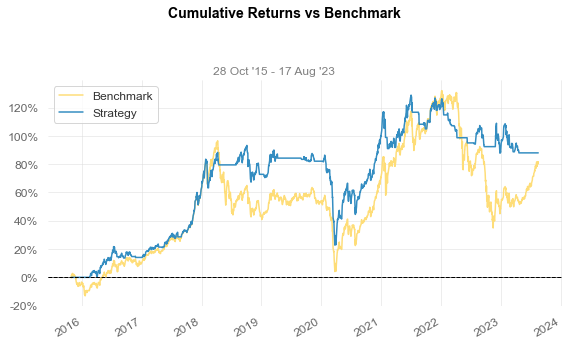

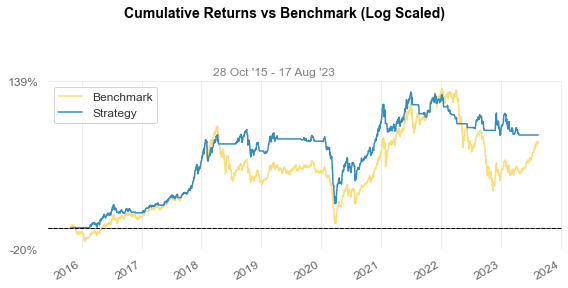

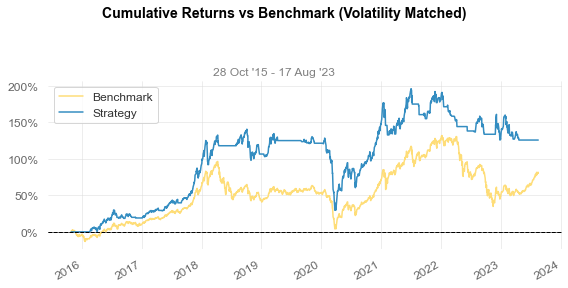

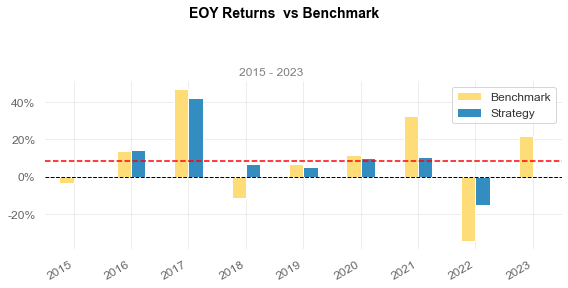

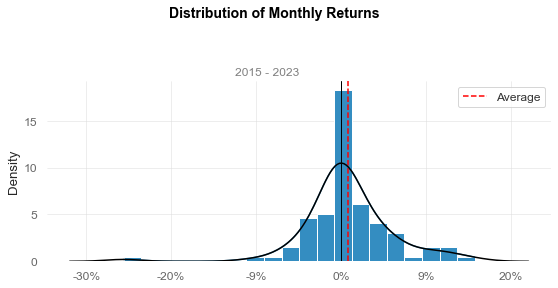

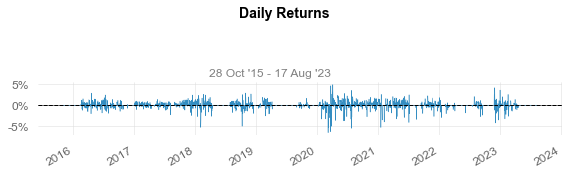

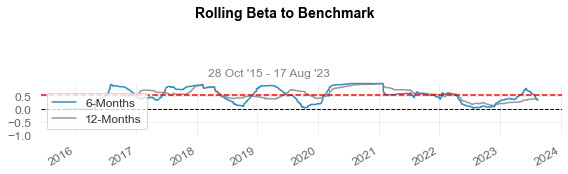

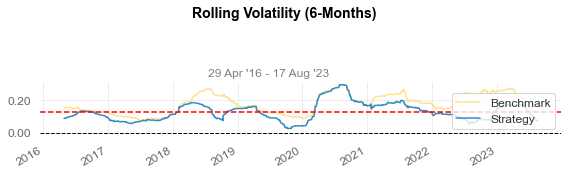

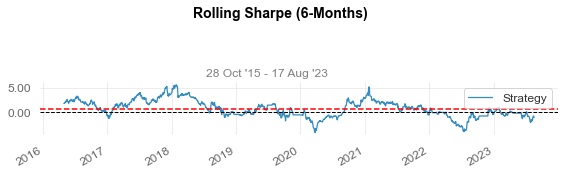

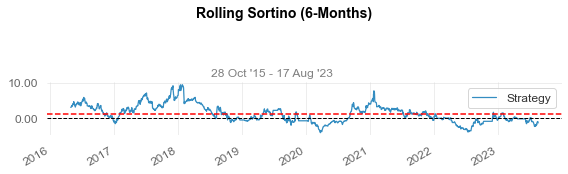

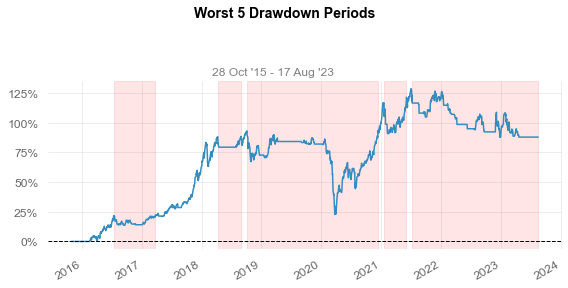

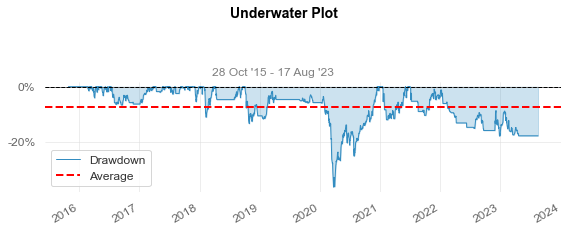

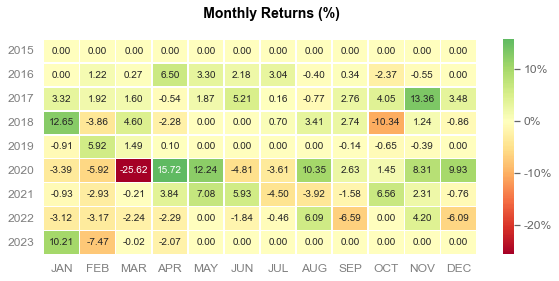

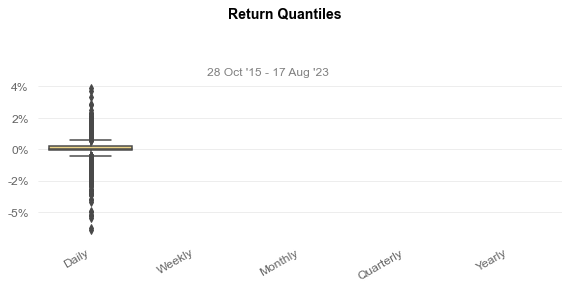

In [223]:
# Compare with buy and hold strategy
performance.performance_report(benchmark='LO')

#### Model parameter tuning
In this section, we try each value against the parameters to find out which set of parameters gives the best results.
It will take long time to run

In [ ]:
# The first parameter store strategy CAGR, the second parameter store period 1, the third parameter store period 2
max_return = 0
max_return_list = [0, 0, 0]
max_sharpe = 0
max_sharpe_list = [0, 0, 0]
max_winrate = 0
max_winrate_list = [0, 0, 0]
min_drawdown = 10
min_drawdown_list = [0, 0, 0]

for period1 in range(100, 200):
    for period2 in range(5, 50):
        vni_regimes = MarketRegimes(vnindex)
        vni_regimes.market_trend_regimes_bb(period1, period2)
        
        strategy_bb = vni_regimes.data.copy()
        strategy_bb['Returns'] = np.log(strategy_bb.Close) - np.log(strategy_bb.Close.shift(1))
        strategy_bb.dropna(inplace = True)
        strategy_bb['Position'] = np.nan
        
        for i in range(1, len(strategy_bb)):
            index = strategy_bb.index[i]

            prev_regime = strategy_bb.iloc[i-1]['LongTrend']
            cur_regime = strategy_bb.iloc[i]['LongTrend']
            if (cur_regime == vni_regimes.Bull and prev_regime == vni_regimes.StrongBull) or \
                (cur_regime == vni_regimes.StrongBear and prev_regime == vni_regimes.Bear):
                strategy_bb.loc[index, 'Position'] = 0

            if (cur_regime == vni_regimes.Bear and prev_regime == vni_regimes.StrongBear) or \
                (cur_regime == vni_regimes.StrongBull and prev_regime == vni_regimes.Bull):
                strategy_bb.loc[index, 'Position'] = 1

        strategy_bb['Position'] = strategy_bb['Position'].fillna(method = 'ffill')
        strategy_bb['Position'] = np.where(np.isnan(strategy_bb.Position), 0, strategy_bb.Position)
        strategy_bb['Position'] = strategy_bb['Position'].shift(1)
        strategy_bb.dropna(inplace = True)
        
        performance = StrategyPerformance(strategy_bb, 'Long VNI Long Trend BB', 'Swing')
        # Find the parameter provide the highes win rate
        if performance.winRate > max_winrate:
            max_winrate_list[0] = performance.winRate
            max_winrate_list[1] = period1
            max_winrate_list[2] = period2
            max_winrate = performance.winRate
        
        # Find the parameter provide the highes CAGR
        if performance.CAGR > max_return:
            max_return_list[0] = performance.CAGR
            max_return_list[1] = period1
            max_return_list[2] = period2
            max_return = performance.CAGR
        
        # Find the parameter provide the highes Sharpe ratio
        if performance.sharpe > max_sharpe:
            max_sharpe_list[0] = performance.sharpe
            max_sharpe_list[1] = period1
            max_sharpe_list[2] = period2
            max_sharpe = performance.sharpe
        
        # Find the parameter provide the lowest drawdown
        if performance.maxDD < min_drawdown:
            min_drawdown_list[0] = performance.maxDD
            min_drawdown_list[1] = period1
            min_drawdown_list[2] = period2
            min_drawdown = performance.maxDD

#### Run backtest with optimize parameter
After running parameter tuning, we find the parameters given the best CAGR is 138 - 9. We will run backtest result on this parameters.

In [224]:
vni_regimes = MarketRegimes(vnindex)
vni_regimes.market_trend_regimes_bb(138, 9)

strategy_bb = vni_regimes.data.copy()
strategy_bb['Returns'] = np.log(strategy_bb.Close) - np.log(strategy_bb.Close.shift(1))
strategy_bb.dropna(inplace = True)
strategy_bb['Position'] = np.nan

for i in range(1, len(strategy_bb)):
    index = strategy_bb.index[i]

    prev_regime = strategy_bb.iloc[i-1]['LongTrend']
    cur_regime = strategy_bb.iloc[i]['LongTrend']
    if (cur_regime == vni_regimes.Bull and prev_regime == vni_regimes.StrongBull) or \
        (cur_regime == vni_regimes.StrongBear and prev_regime == vni_regimes.Bear):
        strategy_bb.loc[index, 'Position'] = 0

    if (cur_regime == vni_regimes.Bear and prev_regime == vni_regimes.StrongBear) or \
        (cur_regime == vni_regimes.StrongBull and prev_regime == vni_regimes.Bull):
        strategy_bb.loc[index, 'Position'] = 1
            
strategy_bb['Position'] = strategy_bb['Position'].fillna(method = 'ffill')
strategy_bb['Position'] = np.where(np.isnan(strategy_bb.Position), 0, strategy_bb.Position)
strategy_bb['Position'] = strategy_bb['Position'].shift(1)
strategy_bb.dropna(inplace = True)

In [225]:
performance = StrategyPerformance(strategy_bb, 'Long VNINDEX based on Long Trend BB 138-9', 'Swing')
performance.strategy_performance()

------------------------Long VNINDEX based on Long Trend BB 138-9 Performance--------------------
Number of Trades: 128
Win Trades: 59
Lose Trades: 67
Win Rate: 46.09375 %
Average Bars Held: 9.53125
Strategy Cumulative Annual Growth Rate: 13.411930703846853 %
Average Return Per trade: 0.7373080737671814 %
Profit Factor: 1.820720209357285
Strategy Volatility: 0.12489037446907747
Strategy Sharpe Ratio: 1.0738962678959387
Stragegy Max Drawdown: 20.641947462795667 %
--------------------------------------------------------------


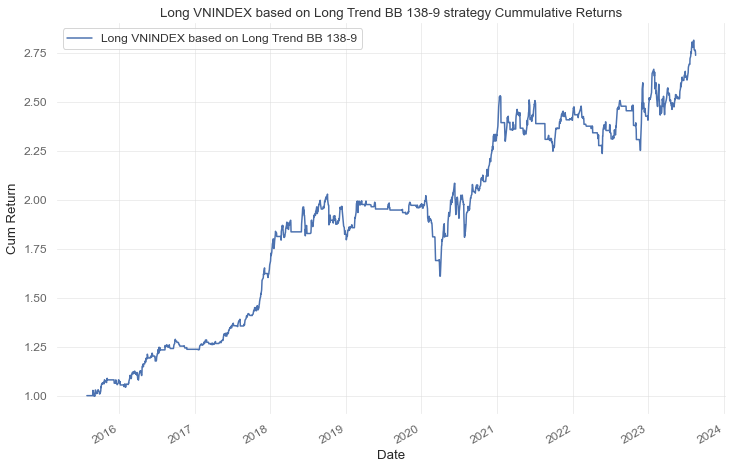

In [226]:
performance.stg_cum_returns_plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-07-30  2015-07-30
End Period                 2023-08-17  2023-08-17
Risk-Free Rate             0.0%        0.0%
Time in Market             61.0%       100.0%

Cumulative Return          173.7%      71.81%
CAGR﹪                     13.31%      6.95%

Sharpe                     1.07        0.46
Prob. Sharpe Ratio         99.82%      89.91%
Smart Sharpe               1.01        0.43
Sortino                    1.48        0.6
Smart Sortino              1.4         0.57
Sortino/√2                 1.05        0.43
Smart Sortino/√2           0.99        0.4
Omega                      1.29        1.29

Max Drawdown               -20.64%     -47.04%
Longest DD Days            683         1137
Volatility (ann.)          12.49%      18.58%
R^2                        0.45        0.45
Information Ratio          0.02        0.02
Calmar                     0.65        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-05,2020-03-30,2020-06-01,605,-20.641947,-16.484756
2,2020-06-11,2020-07-27,2020-10-14,125,-13.204070,-12.665501
3,2021-01-18,2022-05-23,2022-12-02,683,-11.658655,-10.535534
4,2023-01-30,2023-02-27,2023-07-13,164,-8.773985,-8.478287
5,2018-06-12,2018-06-19,2018-08-13,62,-7.497505,-6.896616


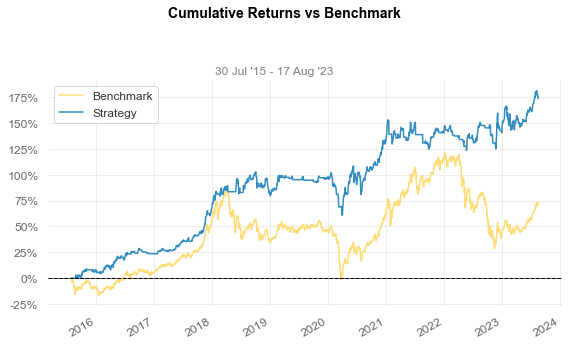

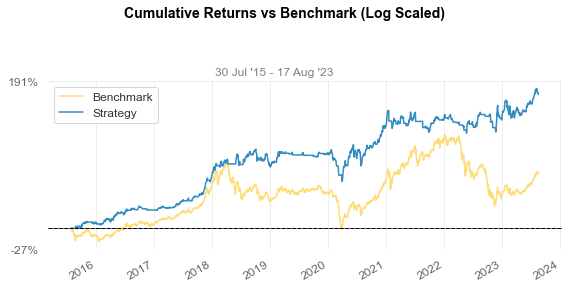

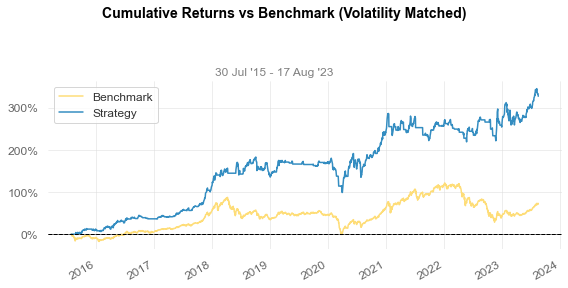

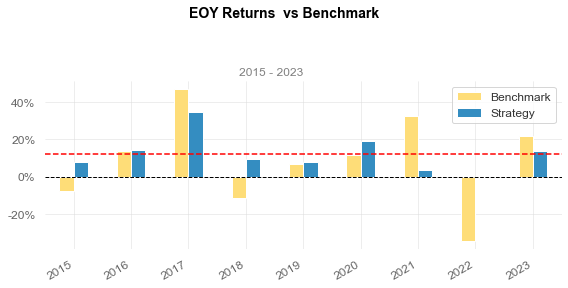

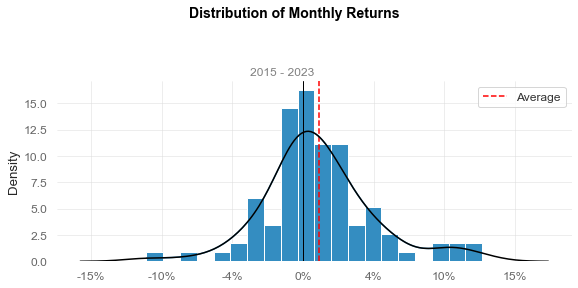

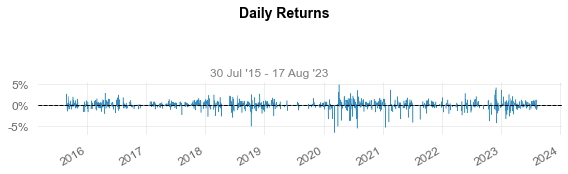

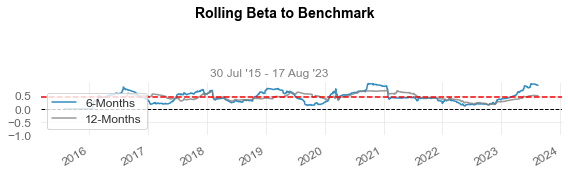

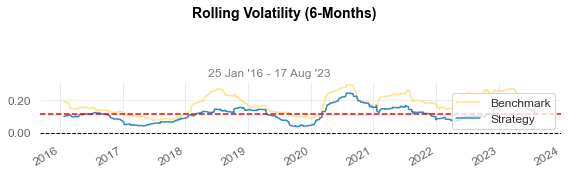

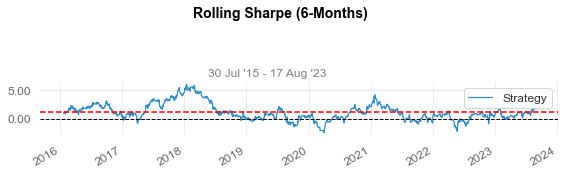

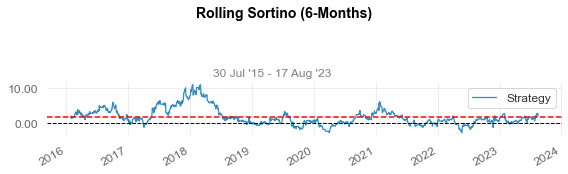

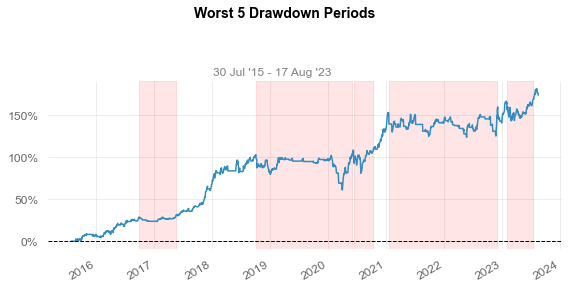

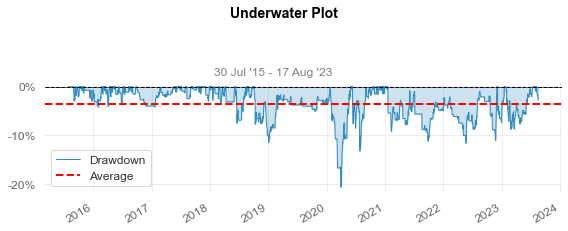

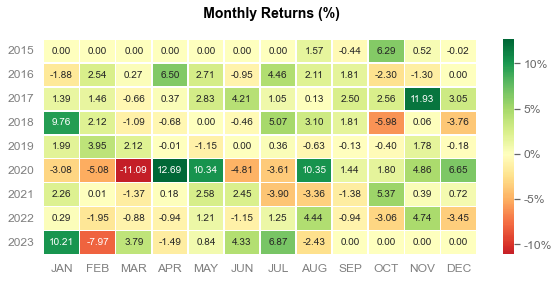

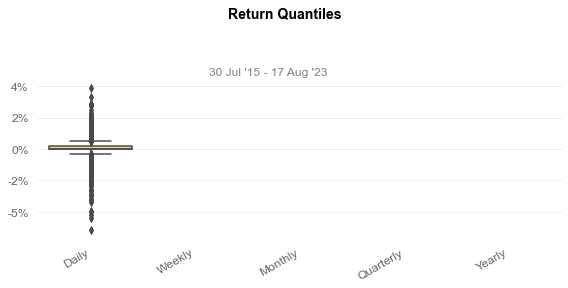

In [227]:
# Compare with buy and hold strategy
performance.performance_report(benchmark='LO')

#### Strategy base on ROC trend

Open Long Position when market regime change from strong bear to higher state or bull to strong bull.
Close Position when market regime change from strong bull to lower state or bear to strong bear

In [228]:
vni_regimes = MarketRegimes(vnindex)
vni_regimes.market_trend_regimes_ROC()

strategy_roc = vni_regimes.data.copy()
strategy_roc['Returns'] = np.log(strategy_roc.Close) - np.log(strategy_roc.Close.shift(1))
strategy_roc.dropna(inplace = True)
strategy_roc['Position'] = np.nan

for i in range(1, len(strategy_roc)):
    index = strategy_roc.index[i]

    prev_regime = strategy_roc.iloc[i-1]['ROCLongTrend']
    cur_regime = strategy_roc.iloc[i]['ROCLongTrend']

    if (cur_regime == vni_regimes.Bull and prev_regime == vni_regimes.StrongBull) or \
        (cur_regime == vni_regimes.StrongBear and prev_regime == vni_regimes.Bear):
        strategy_roc.loc[index, 'Position'] = 0

    if (cur_regime == vni_regimes.Bear and prev_regime == vni_regimes.StrongBear) or \
        (cur_regime == vni_regimes.StrongBull and prev_regime == vni_regimes.Bull):
        strategy_roc.loc[index, 'Position'] = 1
            
strategy_roc['Position'] = strategy_roc['Position'].fillna(method = 'ffill')
strategy_roc['Position'] = np.where(np.isnan(strategy_roc.Position), 0, strategy_roc.Position)
strategy_roc['Position'] = strategy_roc['Position'].shift(1)
strategy_roc.dropna(inplace = True)

In [229]:
performance = StrategyPerformance(strategy_roc, 'Long VNINDEX based on Long Trend ROC', 'Swing')
performance.strategy_performance()

------------------------Long VNINDEX based on Long Trend ROC Performance--------------------
Number of Trades: 59
Win Trades: 26
Lose Trades: 31
Win Rate: 44.06779661016949 %
Average Bars Held: 18.779661016949152
Strategy Cumulative Annual Growth Rate: 4.238922370967679 %
Average Return Per trade: 0.5669997736132453 %
Profit Factor: 1.4292424169102071
Strategy Volatility: 0.12763900378163512
Strategy Sharpe Ratio: 0.3321024330634569
Stragegy Max Drawdown: 32.62328020224138 %
--------------------------------------------------------------


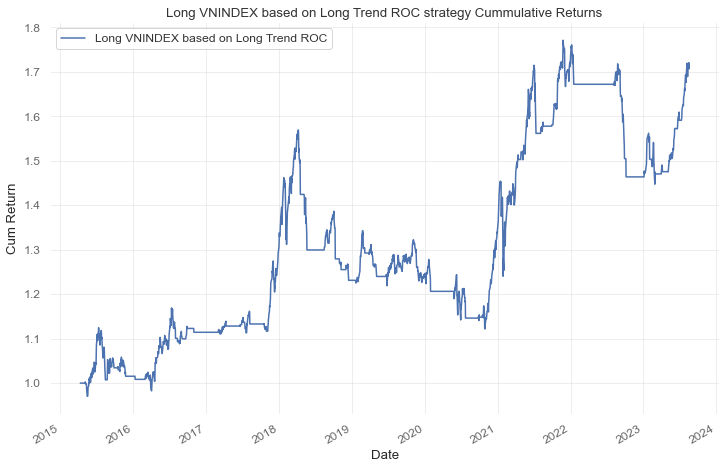

In [216]:
performance.stg_cum_returns_plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-04-13  2015-04-13
End Period                 2023-08-17  2023-08-17
Risk-Free Rate             0.0%        0.0%
Time in Market             55.0%       100.0%

Cumulative Return          41.1%       92.97%
CAGR﹪                     4.21%       8.19%

Sharpe                     0.39        0.52
Prob. Sharpe Ratio         86.55%      93.03%
Smart Sharpe               0.36        0.49
Sortino                    0.52        0.69
Smart Sortino              0.49        0.65
Sortino/√2                 0.37        0.49
Smart Sortino/√2           0.34        0.46
Omega                      1.1         1.1

Max Drawdown               -32.62%     -47.04%
Longest DD Days            1169        1137
Volatility (ann.)          12.76%      18.5%
R^2                        0.48        0.48
Information Ratio          -0.02       -0.02
Calmar                     0.13        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-10,2020-10-29,2021-06-22,1169,-32.623280,-31.220352
2,2021-07-05,2023-02-27,2023-08-17,773,-20.865810,-19.969688
3,2015-07-15,2016-04-04,2017-11-20,859,-17.229962,-15.410803
4,2018-01-29,2018-02-09,2018-02-28,30,-10.270366,-9.520912
5,2017-12-05,2017-12-11,2017-12-28,23,-5.468802,-4.758486


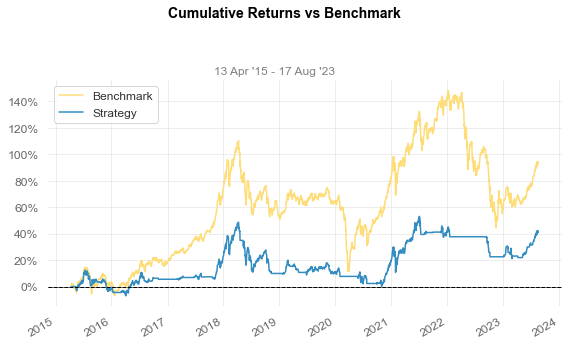

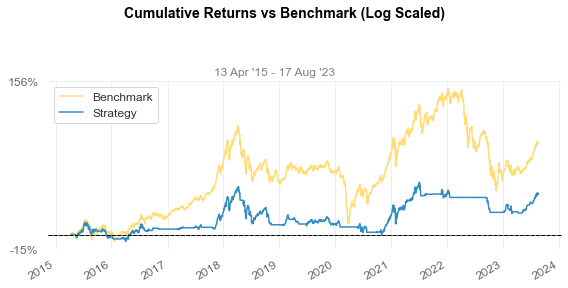

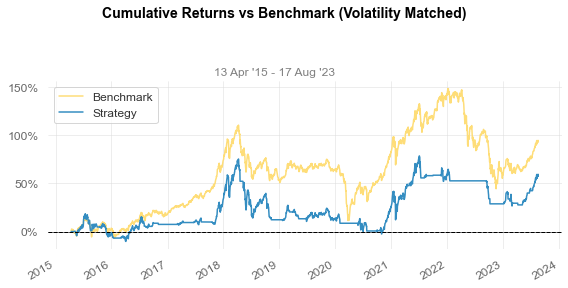

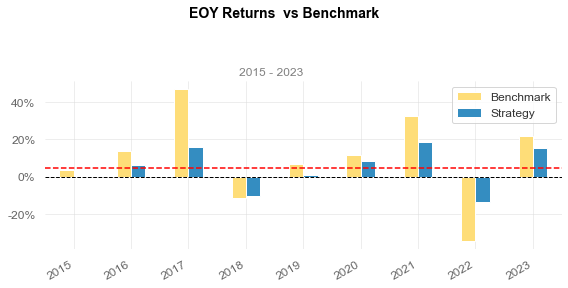

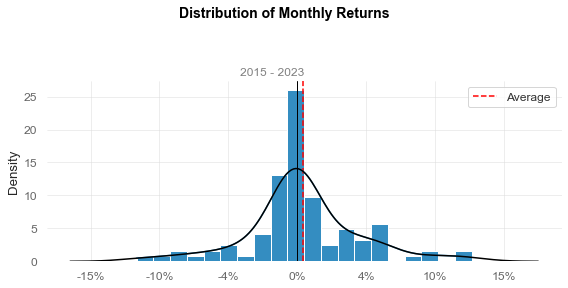

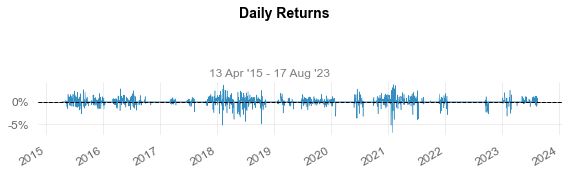

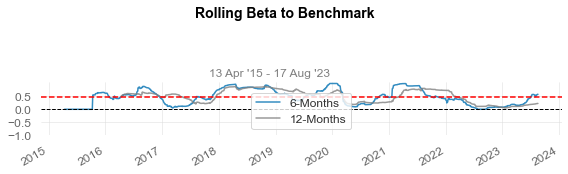

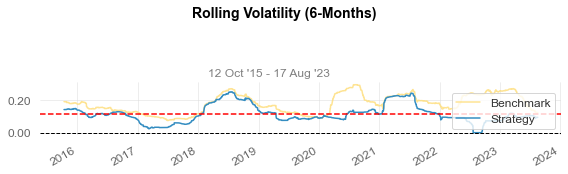

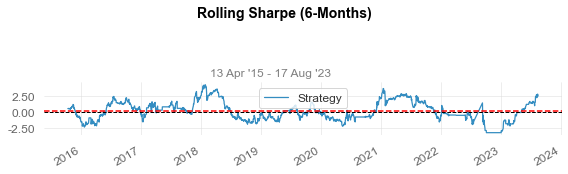

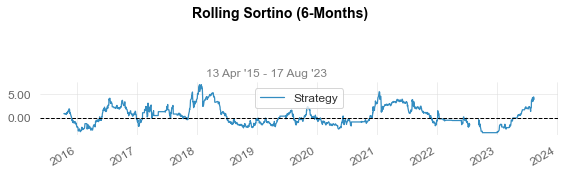

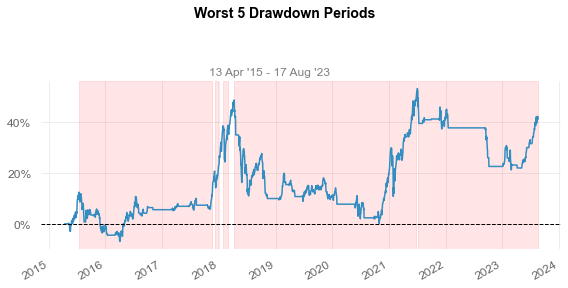

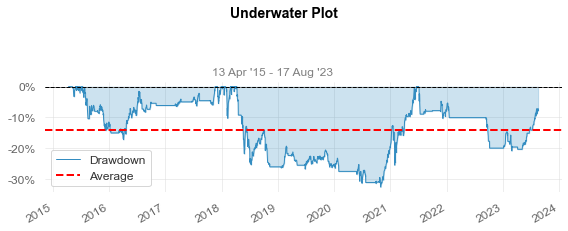

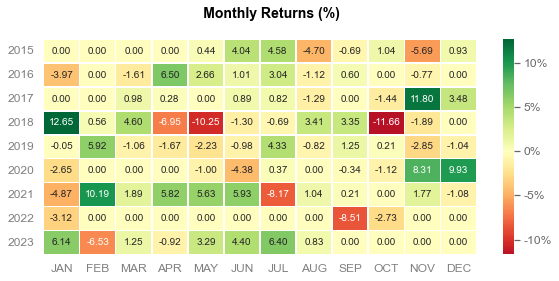

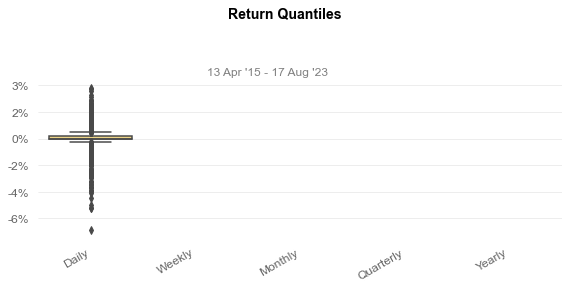

In [230]:
# Compare with buy and hold strategy
performance.performance_report(benchmark='LO')

#### Strategy base on HMM trend
Open Long Position when market regime is different state 3.
Close Position when market regime in state 3

In [263]:
vni_regimes = MarketRegimes(vnindex)
vni_regimes.market_trend_regimes_hmm(nState=3)

strategy_hmm = vni_regimes.data.copy()
strategy_hmm['Returns'] = np.log(strategy_hmm.Close) - np.log(strategy_hmm.Close.shift(1))
strategy_hmm.dropna(inplace = True)
strategy_hmm['Position'] = np.nan

for i in range(len(strategy_hmm)):
    index = strategy_hmm.index[i]

    cur_regime = strategy_hmm.iloc[i]['HMM Trend']

    if cur_regime == 0:
        strategy_hmm.loc[index, 'Position'] = 0
    else:
        strategy_hmm.loc[index, 'Position'] = 1
            
strategy_hmm['Position'] = strategy_hmm['Position'].fillna(method = 'ffill')
strategy_hmm['Position'] = np.where(np.isnan(strategy_hmm.Position), 0, strategy_hmm.Position)
strategy_hmm['Position'] = strategy_hmm['Position'].shift(1)
strategy_hmm.dropna(inplace = True)

Model is not converging.  Current: 6884.253688146149 is not greater than 6884.311258596752. Delta is -0.05757045060272503


Converged: True		 Model Score: 6884.16529986214


In [264]:
performance = StrategyPerformance(strategy_hmm, 'Long VNINDEX based on HMM trend', 'Swing')
performance.strategy_performance()

------------------------Long VNINDEX based on HMM trend Performance--------------------
Number of Trades: 21
Win Trades: 14
Lose Trades: 5
Win Rate: 66.66666666666666 %
Average Bars Held: 80.0
Strategy Cumulative Annual Growth Rate: 23.852351913136438 %
Average Return Per trade: 8.844353698079736 %
Profit Factor: 11.831941462280087
Strategy Volatility: 0.12361781504428727
Strategy Sharpe Ratio: 1.9295238234546617
Stragegy Max Drawdown: 12.581243100609155 %
--------------------------------------------------------------


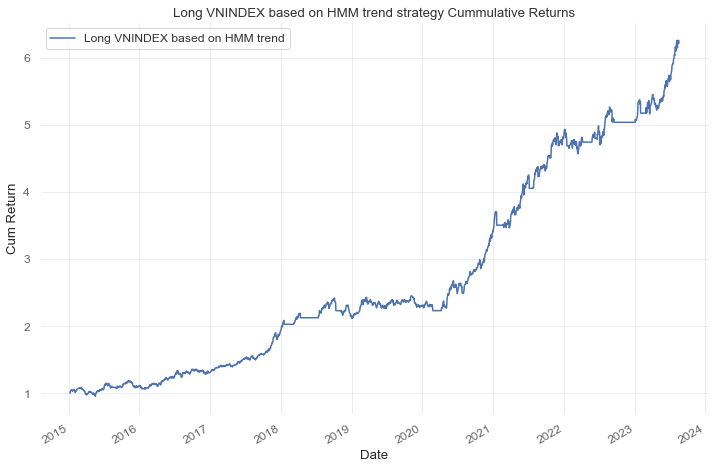

In [265]:
performance.stg_cum_returns_plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-01-07  2015-01-07
End Period                 2023-08-17  2023-08-17
Risk-Free Rate             0.0%        0.0%
Time in Market             84.0%       100.0%

Cumulative Return          521.4%      93.98%
CAGR﹪                     23.62%      8.0%

Sharpe                     1.79        0.51
Prob. Sharpe Ratio         100.0%      93.05%
Smart Sharpe               1.69        0.49
Sortino                    2.59        0.68
Smart Sortino              2.45        0.64
Sortino/√2                 1.83        0.48
Smart Sortino/√2           1.73        0.45
Omega                      1.4         1.4

Max Drawdown               -12.58%     -47.04%
Longest DD Days            227         1137
Volatility (ann.)          12.36%      18.4%
R^2                        0.46        0.46
Information Ratio          0.06        0.06
Calmar                     1.88        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-05,2019-01-03,2019-03-14,160,-12.581243,-11.668434
2,2015-03-05,2015-05-18,2015-07-02,119,-12.087725,-10.789354
3,2015-11-06,2016-02-02,2016-05-05,181,-10.492738,-10.056652
4,2019-11-07,2020-02-24,2020-05-11,186,-9.081322,-8.919522
5,2022-01-07,2022-03-14,2022-06-28,172,-7.385394,-6.549668


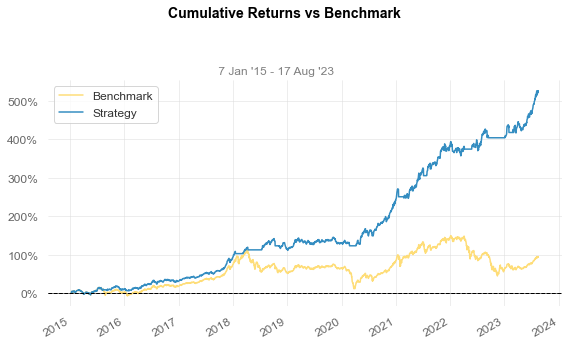

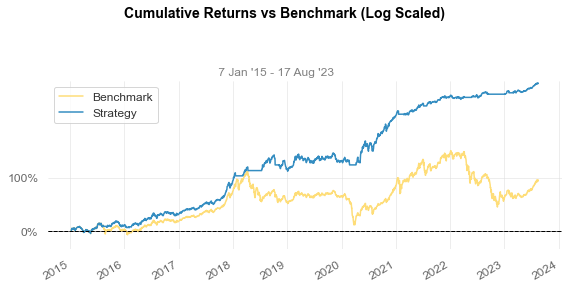

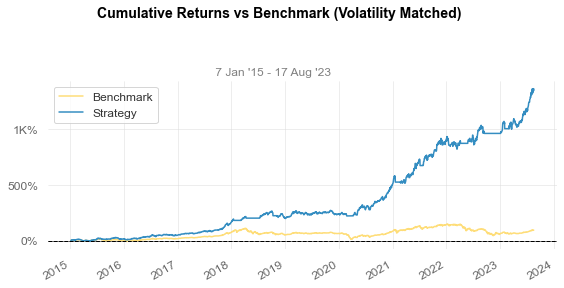

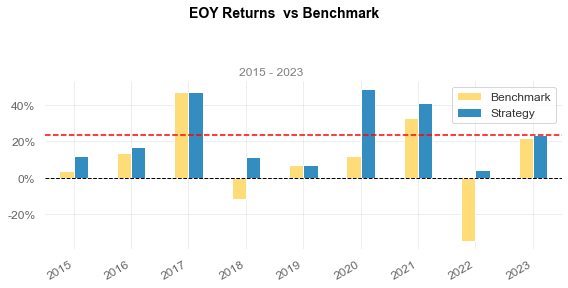

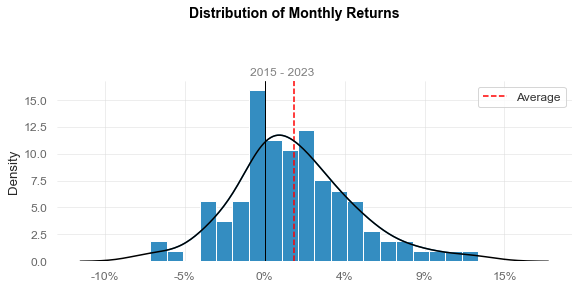

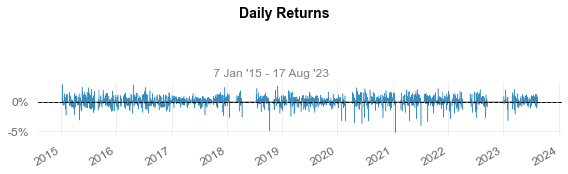

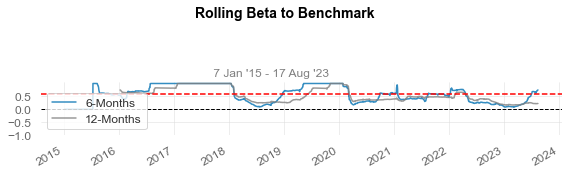

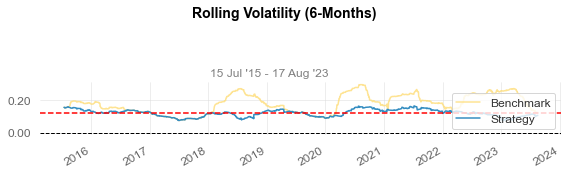

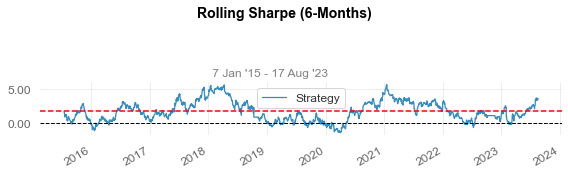

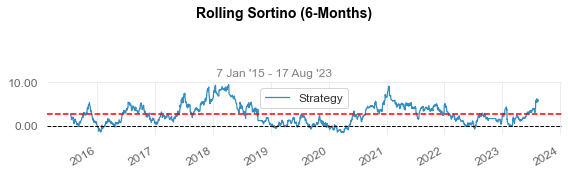

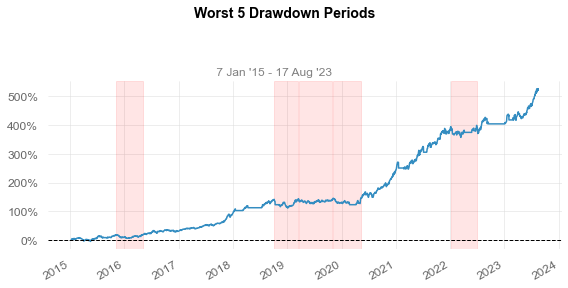

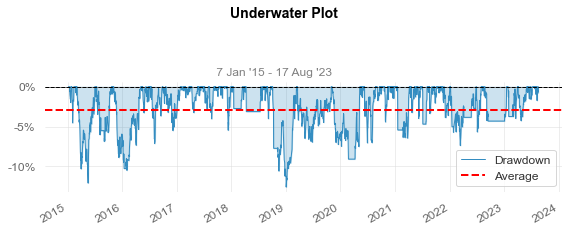

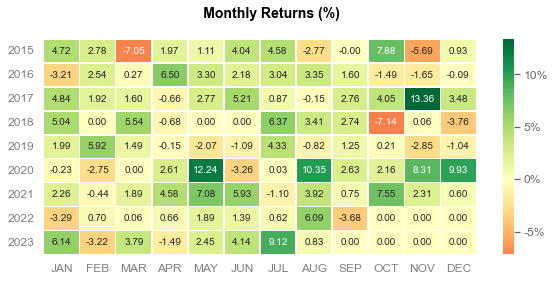

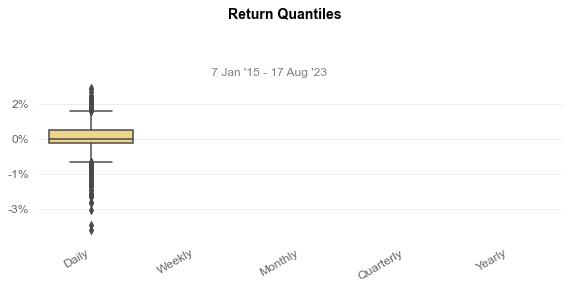

In [266]:
# Compare with buy and hold strategy
performance.performance_report(benchmark='LO')